# 영상 최적화를 위한 MP4와 WebM 간의 품질 비교 분석

본 문서에서는 mp4에서 webm으로의 비디오 형식 전환 후 발생할 수 있는 영상 품질 차이에 대한 신뢰할 수 있는 구체적인 지표를 제공하고자 합니다. 

이를 위해, 피크 신호 대 잡음비 (PSNR), 구조적 유사성 지수 (SSIM), 그리고 시각 정보 충실도 (VIF)를 이용하여 두 비디오 형식 간의 품질 차이를 측정하였습니다. 이 세 가지 지표는 이미지와 비디오 품질 분석에서 널리 사용되는 지표들로, 각각 다양한 측면의 품질 변화를 반영할 수 있습니다.

문서의 코드는 Python으로 작성하였습니다.

## 용어 정리
- **피크 신호 대 잡음비** (PSNR, Peak Signal-to-Noise Ratio): PSNR은 이미지 또는 비디오의 품질을 측정하는 일반적인 방법입니다. 이 값이 클수록 원본과의 차이가 적다는 것을 의미합니다. 즉, 높은 PSNR은 원본 영상에 대한 복제본의 품질이 높다는 것을 의미합니다. 일반적으로 PSNR 값이 30 이하면 낮은 품질, 30~50 사이면 중간 품질, 50 이상이면 높은 품질로 간주합니다.
- **구조적 유사성 지수** (SSIM, Structural Similarity Index): SSIM은 두 이미지 또는 비디오가 얼마나 구조적으로 유사한지를 측정하는 지표입니다. 이 값은 -1과 1 사이의 값으로 측정되며, 1은 완벽한 일치를 나타냅니다.
- **시각 정보 충실도** (VIF, Visual Information Fidelity): VIF는 원본과 압축된 이미지 또는 비디오 사이의 시각적 품질을 측정하는 지표입니다. 이 값이 높을수록 원본과의 시각적 차이가 적다는 것을 의미합니다. VIF는 원본에서 중요한 정보가 얼마나 잘 보존되었는지를 판단하는 데 사용됩니다.

## 데이터 선정과 분석 전략
분석에서는 3840 x 1168의 해상도를 가진 'landing_page_hero_mv.mp4'와 'landing_page_hero_mv.webm' 영상을 대상으로 하였습니다. 13초 길이의 각 영상은 총 420개의 프레임으로 이루어져 있어, 전체 프레임을 분석하는 데 예상 연산 시간이 7~8시간에 이르는 것으로 계산되었습니다. (한 프레임을 처리하는 데 걸리는 시간 * 전체 프레임 수)

프레임을 많이 분석하게 되면 영상의 전체 품질에 대한 평가가 더욱 정확해질 수 있습니다. 그러나, 이러한 방법은 연산에 많은 시간이 소요되며, 실용적인 한계가 있습니다. 따라서, 각 초마다의 시점에서 프레임을 샘플링하는 방식을 선택하였습니다. 그렇기에 분석 결과가 전체 품질을 완벽하게 반영하지는 못할 수도 있다는 점을 인지하고 있습니다.

선택한 13개의 프레임은 영상에서 균일하게 선택되었고, 다양한 장면과 상황을 대표하고 있다고 판단하였습니다. 이로 인해, 분석 결과는 영상의 품질을 객관적이고 신뢰성 있는 방식으로 평가하는 추정치를 제공할 수 있을 것이라고 예상합니다.

## 영상 품질 비교를 위한 분석

In [33]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from sewar import full_ref
import time

# 비디오 파일 열기
cap1 = cv2.VideoCapture('landing_page_hero_mv.mp4')
cap2 = cv2.VideoCapture('landing_page_hero_mv.webm')

# 프레임 속도
fps = cap1.get(cv2.CAP_PROP_FPS)

# 두 비디오의 프레임 수가 같은지 확인
assert cap1.get(cv2.CAP_PROP_FRAME_COUNT) == cap2.get(cv2.CAP_PROP_FRAME_COUNT), "Videos must have same number of frames"

# PSNR, SSIM, VIF의 평균값을 계산하기 위한 리스트
psnr_values = []
ssim_values = []
vif_values = []

# 시간당 한 번 계산
seconds = list(range(14))

for second in seconds:
    cap1.set(cv2.CAP_PROP_POS_FRAMES, second*fps)
    cap2.set(cv2.CAP_PROP_POS_FRAMES, second*fps)

    ret1, frame1 = cap1.read()
    ret2, frame2 = cap2.read()

    # 비디오의 끝에 도달하면 루프를 종료
    if not ret1 or not ret2:
        break

    # PSNR 계산
    psnr = cv2.PSNR(frame1, frame2)
    psnr_values.append(psnr)

    # SSIM 계산
    ssim_value = ssim(frame1, frame2, multichannel=True)
    ssim_values.append(ssim_value)

    # VIF 계산
    vif = full_ref.vifp(frame1, frame2)
    vif_values.append(vif)

    print(f'Second: {second} - PSNR: {psnr}, SSIM: {ssim_value}, VIF: {vif}')

# 평균 PSNR, SSIM, VIF 계산
mean_psnr = np.mean(psnr_values)
mean_ssim = np.mean(ssim_values)
mean_vif = np.mean(vif_values)

print(f'\nMean PSNR: {mean_psnr}')
print(f'Mean SSIM: {mean_ssim}')
print(f'Mean VIF: {mean_vif}')

Second: 0 - PSNR: 51.72941644023464, SSIM: 0.9972663462534271, VIF: 0.8238966366307613
Second: 1 - PSNR: 51.28016002423844, SSIM: 0.9971142961895142, VIF: 0.8159751194658345
Second: 2 - PSNR: 51.247383723464296, SSIM: 0.9971027794204, VIF: 0.815474394953355
Second: 3 - PSNR: 50.36723361153162, SSIM: 0.9963271937936011, VIF: 0.7838099644493267
Second: 4 - PSNR: 49.1149894058391, SSIM: 0.9958364227061036, VIF: 0.7661798912647524
Second: 5 - PSNR: 47.23720458773596, SSIM: 0.9947189440742056, VIF: 0.6951382447109715
Second: 6 - PSNR: 45.81661090893473, SSIM: 0.9917016366640565, VIF: 0.6323098097941838
Second: 7 - PSNR: 45.65164671184295, SSIM: 0.9913484958726788, VIF: 0.628003489702675
Second: 8 - PSNR: 44.78948518622921, SSIM: 0.9899206244938963, VIF: 0.6307590663669763
Second: 9 - PSNR: 46.73905964203763, SSIM: 0.9918846697261742, VIF: 0.6756128021246756
Second: 10 - PSNR: 82.30843610424631, SSIM: 0.9999958685800859, VIF: 3.239495864250043e-07
Second: 11 - PSNR: 60.86661305508816, SSIM: 

#### 결과 분석

- PSNR(Peak Signal-to-Noise Ratio)는 약 53.59로 매우 높습니다. 이는 두 영상 간에 중요한 차이가 거의 없음을 나타냅니다. PSNR 값이 높을수록 두 영상 사이의 차이가 적습니다.
- SSIM(Structural Similarity Index)은 약 0.9959로, 1에 매우 가까워 두 영상의 구조적 유사성이 매우 높음을 나타냅니다. SSIM 값이 1에 가까울수록 두 영상의 구조적 유사성이 높다는 것을 의미합니다.
- VIF(Visual Information Fidelity)는 약 0.7054로, 두 영상 간에 약간의 차이가 있음을 나타냅니다. VIF 값이 1에 가까울수록, 두 영상이 사람의 눈에 똑같이 보인다는 것을 의미합니다.

PSNR 및 SSIM은 두 영상이 매우 유사하다는 것을 나타내지만, VIF 값은 약간의 차이가 있음을 보여줍니다. 이는 눈으로 볼 때 두 영상 사이에 약간의 차이를 인지할 수 있음을 의미할 수 있습니다.


## 초당 분석 결과 시각화

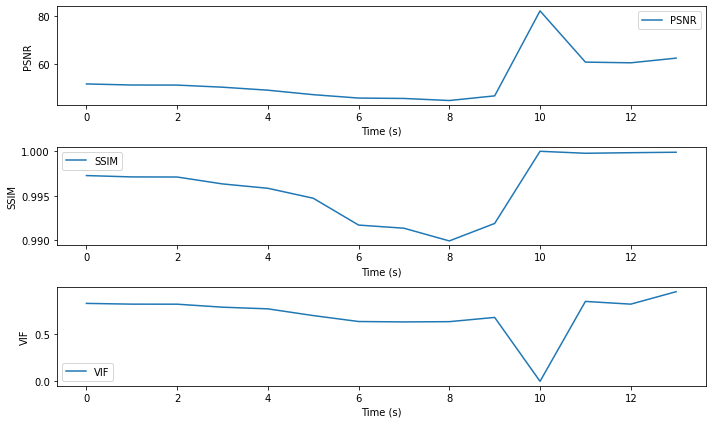

In [34]:
import matplotlib.pyplot as plt

# 시간(초) 벡터 생성
time = list(range(14))

# 그래프 생성
plt.figure(figsize=(10, 6))

# PSNR 그래프
plt.subplot(3, 1, 1)
plt.plot(time, psnr_values, label='PSNR')
plt.xlabel('Time (s)')
plt.ylabel('PSNR')
plt.legend()

# SSIM 그래프
plt.subplot(3, 1, 2)
plt.plot(time, ssim_values, label='SSIM')
plt.xlabel('Time (s)')
plt.ylabel('SSIM')
plt.legend()

# VIF 그래프
plt.subplot(3, 1, 3)
plt.plot(time, vif_values, label='VIF')
plt.xlabel('Time (s)')
plt.ylabel('VIF')
plt.legend()

# 그래프 표시
plt.tight_layout()
plt.show()

초당 분석 결과를 시각화한 결과입니다.

특정 구간(10초)에서 PSNR과 SSIM은 각각 높은 값을 가짐으로써 두 영상이 매우 유사하다는 것을 나타내는 반면, VIF 값이 매우 낮게 나옵니다. 이렇게 낮은 VIF 값은 두 영상 사이에 극도로 차이가 있는 경우에 나타날 수 있지만, PSNR과 SSIM 값이 매우 높은 것을 고려하면 이상치(Outlier)로 판단됩니다.

문제 구간을 확인하기 위해 이상치 구간의 프레임을 시각화하였습니다.

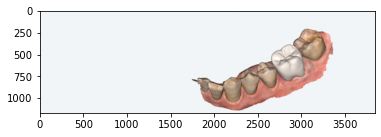

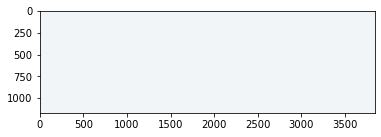

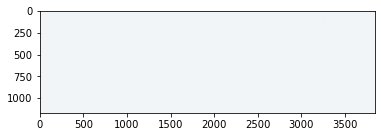

In [42]:
import cv2
import matplotlib.pyplot as plt

def display_frame(video_path, sec):
    cap = cv2.VideoCapture(video_path)

    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_no = int(fps * sec)
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)

    ret, frame = cap.read()

    if not ret:
        print(f"Frame not read correctly at second {sec} for {video_path}")
        return

    # BGR에서 RGB로 변환
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.show()

    cap.release()

# 예시
display_frame('landing_page_hero_mv.mp4', 5)

display_frame('landing_page_hero_mv.mp4', 10)
display_frame('landing_page_hero_mv.webm', 10)

첫 예시로 볼 수 있듯이 특정 구간의 프레임을 추출하는 코드입니다.

이상치에 해당하는 프레임은 아무 정보가 없는 단색 프레임입니다. 
PSNR과 SSIM은 두 이미지 또는 비디오 간의 절대적인 픽셀 차이나 구조적 차이를 측정하는 데 사용되므로, 두 비디오 모두 동일한 단색 프레임을 보여줄 경우 이들의 값이 높게 나올 수 있습니다.
반면에 VIF는 인간 시각의 특성을 고려하여 품질을 평가하므로, 완전한 단색 프레임에서는 별도의 시각적 정보가 없다고 판단하여 점수가 매우 낮게 나올 수 있습니다.

## 결론
피크 신호 대 잡음비, 구조적 유사성 지수, 시각 정보 충실도 세가지 메트릭을 사용하여 압축 전, 후 영상을 비교분석하였습니다.

단순 수치로는 피크 신호 대 잡음비 및 구조적 유사성 지수는 두 영상이 매우 유사, VIF 값은 약간의 차이가 있음으로 해석하였습니다. 하지만 이는 단색 프레임 특성 상 나오는 문제였으므로 이상치를 제거하고 평균을 다시 구해야합니다.
이상치를 제거한 평균은 다음과 같습니다.

```
# Without outlier
Mean PSNR: 51.08
Mean SSIM: 0.9965
Mean VIF: 0.7580
```

상대적으로 VIF 값이 다소 낮기 때문에, 특정 상황에서 인간의 눈으로 보았을 때 두 비디오 간에 차이를 느낄 수 있음을 의미합니다. 그러나 전체적인 품질 지표들이 상당히 높게 나타나기에 원본 비디오와 인코딩된 비디오 간에 큰 차이가 없다고 판단할 수 있습니다.